In [1]:
# 데이터 구성 : Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Scaling
from sklearn.preprocessing import StandardScaler

# 데이터 분할
from sklearn.model_selection import train_test_split

# 로지스틱 회귀
from statsmodels.api import Logit

# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

# 의사결정나무
from sklearn.tree import DecisionTreeClassifier

# 그래디언트부스팅
from sklearn.ensemble import GradientBoostingClassifier

# 평가함수
from sklearn.metrics import accuracy_score

# confusion matrix
from sklearn.metrics import confusion_matrix

# column counter
from collections import Counter

import graphviz

from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

import os
import scipy.stats as stats


from sklearn.metrics import f1_score, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
matplotlib.rc("font", family="NanumGothic")
plt.rcParams['axes.unicode_minus']=False


In [3]:
import warnings

warnings.filterwarnings("ignore")

# 분석배경

oo공장의 고객사에서 최근 들어 'Scale'불량 발생 증가'라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale 불량이 급증한 것을 확인할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 **불량 발생의 근본 원인**을 찾고 결과를 해석하여 개선 기회를 도출한다.

**발생 현황**  

|발생원인|압입흠|Scratch|두께부족|Scale|계|
|-----|---|-------|----|-----|---|
|**발생률(%)**|1.3|0.5|0.4|<span style="color:red">5.0</span>|7.2%|


Scale 불량을 줄이기 위하여 엔지니어들과의 협의를 통하여 다음과 같은 잠재적 원인을 도출하였다.
    * 잠재 인자 선정 및 방향성 확인
    * 도출된 잠재 인자와 분석 결과 비교 예정  
    
    
|SCALE발생|가열로 가열대온도|가열로 균열대온도|가열로 추출온도|Hot Scale Breaker|사상 압연 온도|압연간 Descaling 횟수|판두께|
|-----|---|-------|----|-----|---|---|---|
|없음|저|저|저|적용|저|증가|후|
|발생|고|고|고|미적용|고|감소|박|

In [4]:
df=pd.read_csv("../data/BigData/SCALE불량.csv", encoding="cp949", parse_dates=["ROLLING_DATE"])
df.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

In [5]:
#==================================================================
# fun_select_cols(v_data, pattern = None, start = None)
# 변수명 선택 및 리스트 생성
# -.input:
# v_data:input data, start:입력 문자로 시작하는 변수명 탐색, pattern:입력 문자를 포함하는 변수명 탐색
# -.output:
#다
#==================================================================
def fun_select_cols(v_data, pattern = None, start = None):
    cols = v_data.columns.tolist()
    if pattern:
        cols = [col for col in cols if col.find(pattern) > -1]
    if start:
        cols = [col for col in cols if col.startswith(start) > 0]
    return cols


#==================================================================
# fun_check_class_level(v_data, v_start=None, v_pattern=None)
# 범주형 변수 수준 및 자료 수 확인
# -.input:
# v_data:input data, v_start:입력 문자로 시작하는 변수명 탐색, v_pattern:입력 문자를 포함하는 변수명 탐색
# -call function:fun_select_cols
# -.output:
#
#==================================================================
def fun_check_class_level(v_data, v_start=None, v_pattern=None):

    #list_cols= df_machine.select_dtypes(include='object').columns
    #list_cols = fun_select_cols(v_data, start = v_start, pattern = v_pattern)

    for v_col in list_cols:
        print()    
        print("변수: ", v_col, "Level = ",Counter(v_data[v_col]))


#===================================================================
# fun_plot_hist(v_data, yvar, xvar, alpha = 0.5)
# Histogram, 범주형 변수의 수준(level)별 색깔 구분
# -.input:
# v_data:input data, yvar:목표변수(범주형), x:분석변수(연속형), alpha:transparency(투명도)
# -.output:
#
#==================================================================
def fun_plot_hist(v_data, yvar, xvar, alpha = 0.5, bins=None):
    levels = v_data[yvar].unique()
    for level in levels:
        plt.hist(v_data[v_data[yvar] == level][xvar], label = level, alpha = alpha, bins=bins)
    plt.title(xvar)
    plt.legend()


#==================================================================
# fun_stat_by_class(v_data, var_anal, var_class = "JUDGE")
# 범주형 변수 수준별 분석 변수 통계량 생성
# -.input:
#   v_data:input data, var_class:범주형 변수, var_anal:분석 변수
# -.output:
#
#==================================================================
def fun_bstat_by_class(v_data, var_anal, var_class ):    
    _tmp = v_data.groupby(var_class)[var_anal].describe().T
    _tmp.reset_index(inplace = True)
    return pd.pivot_table(data = _tmp, index = "level_0", columns = "level_1", values = list(np.unique(v_data[var_class])))


#==================================================================
# fun_anova(v_data, yvar, xvar)
# 분산분석(ANOVA), stats.f_oneway() 활용
# -.input:다
# v_data:input data, yvar:목표변수(범주형), x:분석변수(연속형) -일반적인 명칭 구분과 상이함
# -.output:
# fv:F 통계량, pv:p-value(F)다
#
#==================================================================
def fun_anova(v_data, yvar, xvar):
    dict_data = dict()
    y_level = v_data[yvar].unique()
    for i in y_level:
        dict_data[i] = v_data[v_data[yvar] == i][xvar]
    fv, pv = stats.f_oneway(dict_data[y_level[0]], dict_data[y_level[1]])
   
    print("분석 통계량 => ")
    print("statistic:(F) {0:.3f}, p-value: {1:.3f}".format(fv, pv))
    return fv, pv


#==================================================================
# fun_chi2(v_data, yvar, xvar, heatmap = True, print_crosstab = True)
# 카이제곱 분석
# -.input:다
#   v_data:input data, yvar:Y축, 목표변수(범주형), xvar:X축, 분석변수(범주형),
#   heatmap:heatmap 표시, print_crosstab:교차표(cross tabulate) 표시
# -.output:
#
#==================================================================
def fun_chi2(v_data, yvar, xvar, heatmap = True, print_crosstab = True):    
    _tmp_cross = pd.crosstab(v_data[yvar], v_data[xvar])
    chi2, p, dof, expt = stats.chi2_contingency(_tmp_cross)
    print("카이제곱 통계량 =>")
    print("Chi2: {0:.3f}, p-value: {1:.3f}".format(chi2, p))
   
    # heatmap
    if heatmap:
        cmap = sns.cubehelix_palette(as_cmap=True)
        sns.heatmap(_tmp_cross, cmap = cmap, annot=True, fmt="d")
        plt.title(xvar)
        plt.show()
       
    # print data
    if print_crosstab:
        print("교차표(빈도) =>")        
        print(_tmp_cross)
        print()
        print("교차표(확률) =>")            
        print(pd.crosstab(v_data[yvar], v_data[xvar], normalize = "columns"))
    return chi2, p

# 데이터 구조 확인

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
PLATE_NO             720 non-null object
ROLLING_DATE         720 non-null object
SCALE                720 non-null object
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null object
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(12), object(8)
memo

In [7]:
df.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

# EDA

* 연속형 데이터 통계량 요약

In [8]:
temp=df[['PT_THK','PT_WDTH','PT_LTH','PT_WGT','FUR_NO_ROW','FUR_HZ_TEMP','FUR_HZ_TIME',
   'FUR_SZ_TEMP','FUR_SZ_TIME','FUR_TIME','FUR_EXTEMP','ROLLING_TEMP_T5', 'ROLLING_DESCALING']]

In [9]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
PT_THK,720.0,29.267857,19.152651,12.03,16.09,20.13,40.00,100.34
PT_WDTH,720.0,2807.127778,517.839690,1800.00,2466.00,2725.00,3125.00,4575.00
PT_LTH,720.0,34323.269444,13828.434837,7893.00,22663.00,37380.00,43735.00,54917.00
PT_WGT,720.0,41481.777778,24751.322015,7820.00,17757.50,36120.00,61120.00,115080.00
FUR_NO_ROW,720.0,1.497222,0.500340,1.00,1.00,1.00,2.00,2.00
FUR_HZ_TEMP,720.0,1155.338889,20.866398,1103.00,1139.00,1158.00,1171.00,1206.00
FUR_HZ_TIME,720.0,88.527778,37.660799,43.00,65.00,75.00,101.00,312.00
FUR_SZ_TEMP,720.0,1149.666667,17.571788,1113.00,1132.00,1155.00,1164.00,1185.00
FUR_SZ_TIME,720.0,78.802778,36.421004,35.00,57.75,67.50,86.00,294.00
FUR_TIME,720.0,300.563889,45.390303,221.00,257.00,304.00,342.00,398.00


**Rolling_temp_t5(가열대 온도) 에서 이상치 발견**

In [10]:
df[df['ROLLING_TEMP_T5']==0].T

,41,184,185,494,495,496
PLATE_NO,PB562815,PB562958,PB562959,PB563268,PB563269,PB563270
ROLLING_DATE,2008-08-01:02:23:09,2008-08-01:10:00:06,2008-08-01:09:94:29,2008-08-02:01:10:40,2008-08-02:01:10:36,2008-08-02:01:10:23
SCALE,양품,양품,양품,양품,양품,양품
SPEC,GL-E36-TM,JS-SM490YB,JS-SM490YB,PILAC-BT33,PILAC-BT33,NV-D32-TM
STEEL_KIND,T8,C0,C0,T5,T5,T0
PT_THK,55.51,16.09,16.09,80.82,80.82,40.35
PT_WDTH,3765,2221,2221,2085,2085,2497
PT_LTH,11398,43596,43596,12919,13176,23592
PT_WGT,37400,61150,61150,17090,17430,37320
FUR_NO,3호기,3호기,3호기,2호기,1호기,3호기


**ROLLING_TEMP_T5의 이상치(0)의 대체 값을 찾아보자**

In [11]:
temp=df[df['ROLLING_TEMP_T5']!=0]
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
PT_THK,714.0,29.108091,18.994878,12.03,16.09,20.13,38.43,100.34
PT_WDTH,714.0,2809.885154,516.293303,1800.00,2469.00,2727.50,3125.00,4575.00
PT_LTH,714.0,34404.029412,13799.227159,7893.00,22664.50,37380.00,43771.75,54917.00
PT_WGT,714.0,41506.078431,24799.277300,7820.00,17780.00,36090.00,61120.00,115080.00
FUR_NO_ROW,714.0,1.497199,0.500343,1.00,1.00,1.00,2.00,2.00
FUR_HZ_TEMP,714.0,1155.459384,20.844557,1103.00,1139.00,1158.00,1171.00,1206.00
FUR_HZ_TIME,714.0,88.563025,37.780529,43.00,65.00,74.50,101.00,312.00
FUR_SZ_TEMP,714.0,1149.774510,17.508271,1113.00,1133.00,1155.00,1164.00,1185.00
FUR_SZ_TIME,714.0,78.899160,36.551271,35.00,57.00,68.00,86.00,294.00
FUR_TIME,714.0,300.183473,45.297442,221.00,257.00,304.00,342.00,398.00


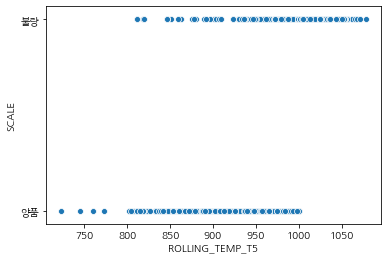

In [12]:
sns.scatterplot(x='ROLLING_TEMP_T5',y='SCALE',data=temp)

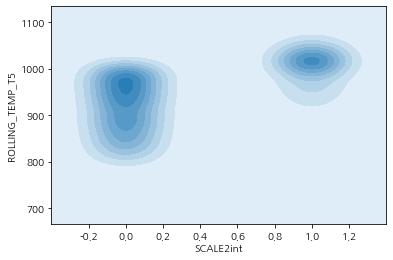

In [13]:
temp['SCALE2int'] =np.where(temp['SCALE']=="양품",0,1)
sns.kdeplot(temp['SCALE2int'], temp['ROLLING_TEMP_T5'], shade=True)


ROLLING_TEMP_T5가 높을 수록 Scale이 불량인 것이 많았다.

# <span style="color:red">교수님의 조언대로 ROLLING_TEMP_T5가 0인 값들은 제외하겠습니다.</span>

* 양품-불량 비율 확인

In [14]:
temp_scale=pd.DataFrame(df['SCALE'].value_counts())

In [103]:
temp_scale

,SCALE
양품,489
불량,231


([<matplotlib.patches.Wedge at 0x7f3cad2a8b38>,
 [Text(-0.5869759907341133, 0.9303005892192622, '양품'),
  Text(0.5869759907341137, -0.930300589219262, '불량')],
 [Text(-0.3201687222186072, 0.5074366850286884, '67.92%'),
  Text(0.3201687222186074, -0.5074366850286882, '32.08%')])

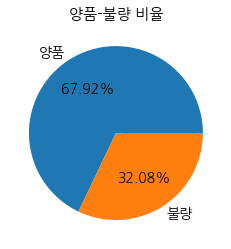

In [15]:
group_names=['양품', '불량']
plt.title('양품-불량 비율', fontsize=15)
plt.pie(x="SCALE",data=temp_scale,autopct='%1.2f%%',labels=group_names, textprops={'fontsize': 14})

전체 생산 제품 중 32.08%의 제품이 SCALE을 가진것으로 확인되었다.

* SPEC : 제품규격  

**AB**:미국, **BV**:프랑스, **GL**:독일, **COMMON**: , **KS**:한국산업표준, **NV**:노르웨이, **LR**:영국, **JS**:일본, **KR**:한국,  
**V42**:?, **PILAC**:TMCP형 강,**CCS**:중국, **A**:?, **SA**:자동차, **NK**:일본  

SPEC을 구성하는 문자열의 의미는 위와 같으므로, '-'를 기준으로 앞에 위치한 국가 코드만 남겨 국가별 요구 규격에 대한 정보를 보며 분석을 시도하겠다.

# SPEC TM인거랑 아닌거 나누기이이이잉

In [16]:
df['SPEC_prefix']=[str(d).split("-")[0] for d in df['SPEC']]

In [17]:
df['SPEC_prefix'].value_counts()

JS         146
LR         105
NV         105
BV          86
GL          56
PILAC       40
KR          31
KS          28
COMMON      28
SA283       21
NK          20
AB/EH36     17
AB/A         7
AB/B         6
A283         6
AB/AH32      5
V42JBN3      4
API          2
A516         2
AB/EH32      2
CCS          1
A709         1
A131         1
Name: SPEC_prefix, dtype: int64

SPEC은 삭제하고 SPEC의 앞글자만 남긴다.(dummy 데이터 생성시 너무 많은 변수가 생기는 걸 방지하고자...)

In [18]:
df.drop("SPEC",axis=1, inplace=True)

In [19]:
df.columns

Index(['PLATE_NO', 'ROLLING_DATE', 'SCALE', 'STEEL_KIND', 'PT_THK', 'PT_WDTH',
       'PT_LTH', 'PT_WGT', 'FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'WORK_GR',
       'SPEC_prefix'],
      dtype='object')

* 위의 엔지니어들이 도출한 잠재인자에 대한 검정 실행

**1) 가열로 가열대 온도가 높을수록 불량이 많이 발생한다**

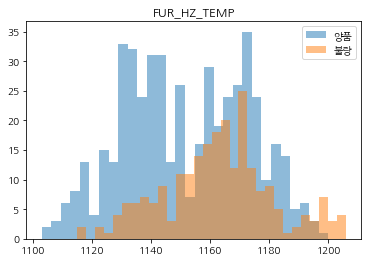

In [20]:
fun_plot_hist(df,'SCALE','FUR_HZ_TEMP',bins=30)

온도가 높아질수록 불량률이 많아지는 것을 맞다. 하지만 가열대온도가 **1152정도 부근에서 양품 대비 불량률이 상당히 많이 증가하고 1184가 될때 다시 감소**한다.

**2) 가열로 균열대 온도가 높을수록 불량이 많이 발생한다.**

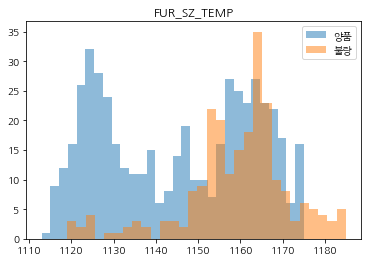

In [21]:
fun_plot_hist(df,'SCALE','FUR_SZ_TEMP',bins=30)

가열로 균열대 온도가 증가할수록 불량률이 많아지는 것은 사실이다. 특히 균열대 **온도가 1146정도 부근에서 양품 대비 불량률이 상당히 많이 증가하고 1166이 될때 다시 감소**한다.

**3) 가열로 추출 온도가 높을 수록 불량이 많아진다.**

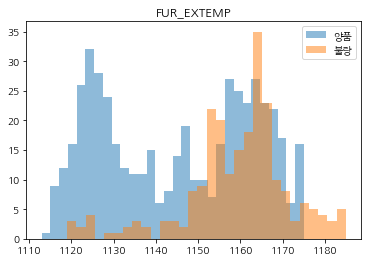

In [22]:
fun_plot_hist(df,'SCALE','FUR_EXTEMP',bins=30)

추출온도가 증가할수록 불량률이 많아지는 것은 사실이다. 추출시 온도가 1148 ~ 1166 일때 양품 대비 불량률이 상당히 많이 증가 하고 있는 것을 확인 할 수 있다.특히 추출시 온도가 1152도~1154도일때와 1164도 일때는 양품의 개수보다 불량 개수가 많은 것을 확인 할 수 있고, 이 온도 일때를 주의깊게 살펴봐야 한다.

**4) Hot Scale Breaker를 미적용하면 불량률이 높다.**

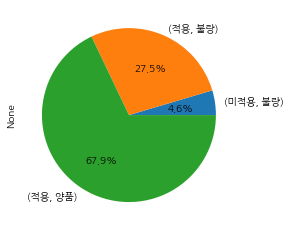

In [23]:
df_groupby_tot= df.groupby(['HSB', 'SCALE']).size()
df_groupby_tot.plot.pie(y='SCALE', autopct='%.1f%%')

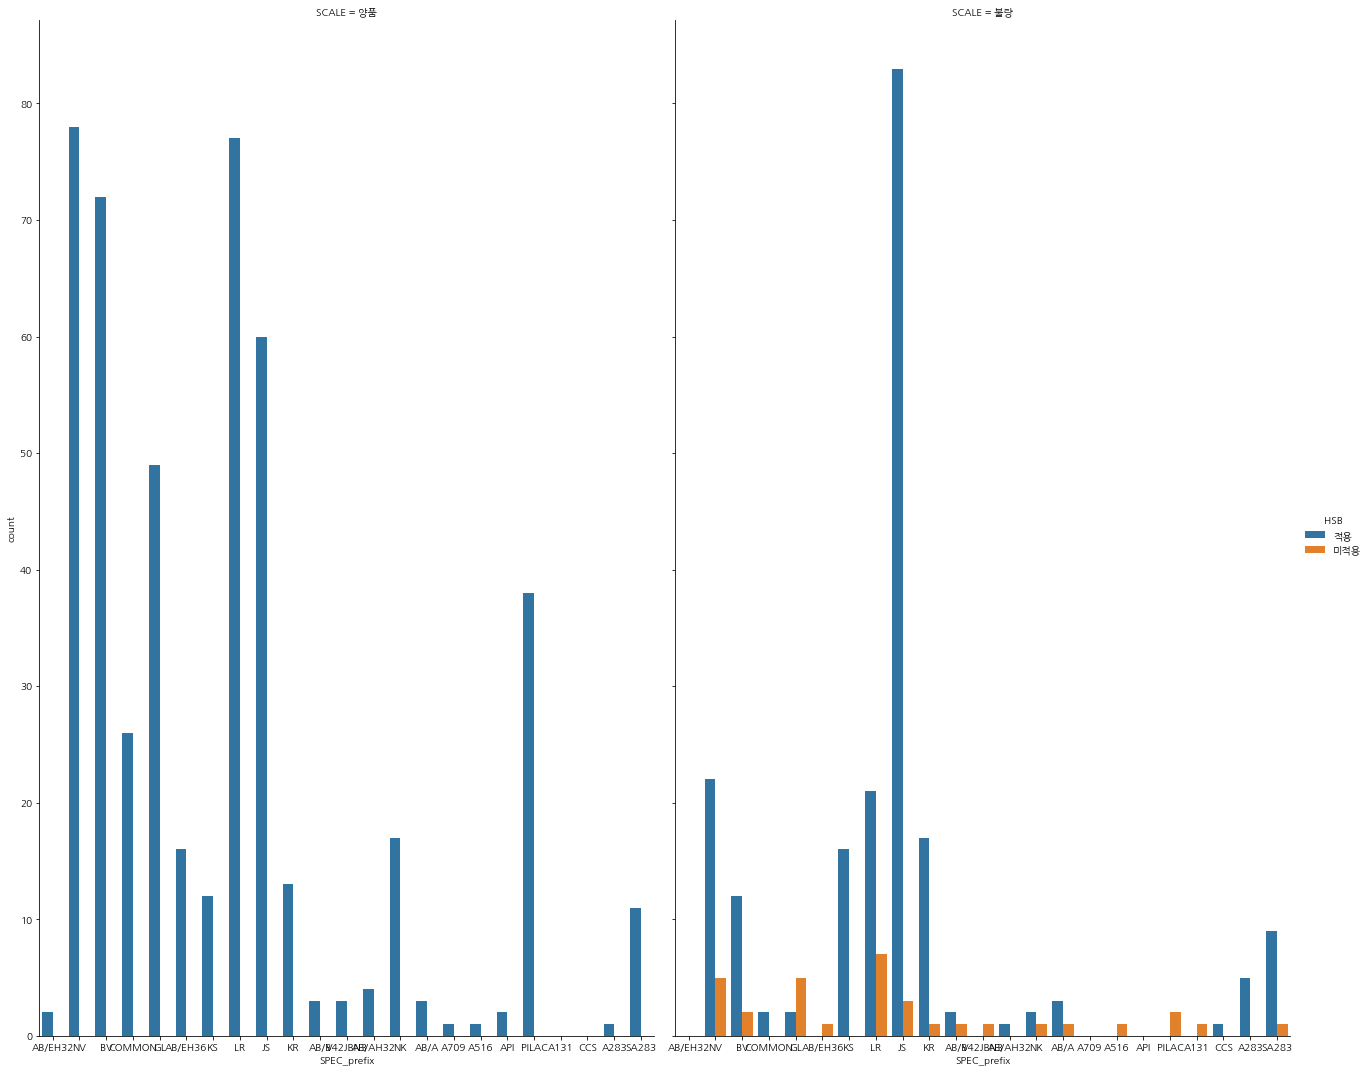

In [24]:
sns.catplot(x="SPEC_prefix", hue="HSB", col="SCALE",data=df, kind="count", height=15, aspect=0.6)

HSB를 적용하지 않은 경우 모든 제품에서 불량이 발생한 것으로 보아 HSB적용여부는 SCALE 발생에 영향인자로 작용하고 있음을 알 수 있다.

**5) 사상 압연 온도가 높을수록 불량이 많이 발생한다.**

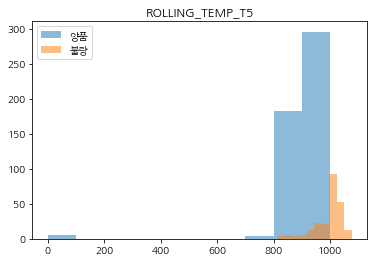

In [25]:
fun_plot_hist(df,'SCALE','ROLLING_TEMP_T5')

압연온도가 1000이상일때 불량률이 급격하게 증가함과 동시에 모든제품에 불량이 발생한다.

**6) 압연간 Descaling 횟수가 적을 수록 불량이 많이 발생한다.**

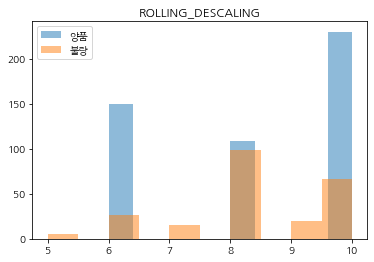

In [26]:
fun_plot_hist(df,'SCALE','ROLLING_DESCALING')

Descaling을 7회 이상 시행하였을 경우 불량률이 급격하게 증가하다 10회를 한 순간 다시 감소하는 모습을 확인할 수 있었다.

**7) 판두께가 얇아질수록 불량이 많아진다.**

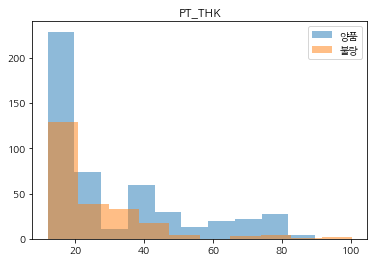

In [27]:
fun_plot_hist(df,'SCALE','PT_THK')

판두께가 얇아질수록 불량률이 증가하는 것은 사실이다. 판 두께가 50을 넘어서는 순간 불량률은 급격히 감소하며 안정적인 양품 생산을 해내고 있는 것을 확인 할 수 있다.

**추가 변수간의 관계 파악**

- 강종의 종류별 압연온도의 차이확인

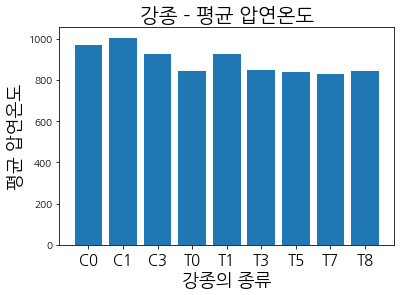

In [28]:
groupedbySTEEL_KIND_se=df.groupby('STEEL_KIND')['ROLLING_TEMP_T5'].mean()

groupedbySTEEL_KIND=pd.DataFrame(groupedbySTEEL_KIND_se)

label = groupedbySTEEL_KIND.index
label
index = np.arange(len(label))

# Basic Bar Chart

plt.bar(index, groupedbySTEEL_KIND_se)

plt.title('강종 - 평균 압연온도', fontsize=20)

plt.xlabel('강종의 종류', fontsize=18)

plt.ylabel('평균 압연온도', fontsize=18)

plt.xticks(index, label, fontsize=15)

plt.show()



강종의 종류와 상관없이 평균 압연온도는 800을 넘기고 있으며 RAW데이터에 포함되어있던 0은 이상치로 판단가능하다.

* PLATE의 무게별 불량률 추이

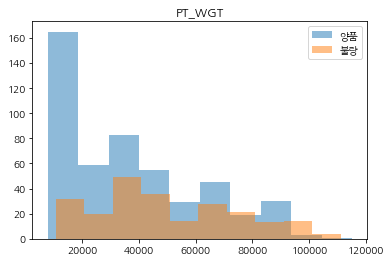

In [29]:
fun_plot_hist(df,'SCALE','PT_WGT')

무게가 40000이하인 제품을 주로 생산하고 잇지만 불량의 수는 무게별 생산량과 상관없이 꾸준히 20~40을 유지하고 있다. 즉, PT_WGT(PLATE의 무게)는 SCALE 발생의 영향인자로 볼 수 없다.

* HSB 여부별 압연온도와 불량률 확인

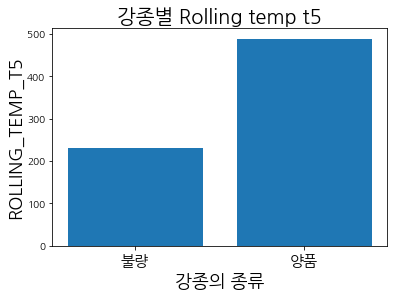

In [30]:
groupedbySTEEL_KIND_se=df.groupby('SCALE')['HSB'].count()
groupedbySTEEL_KIND=pd.DataFrame(groupedbySTEEL_KIND_se)

label = groupedbySTEEL_KIND.index
label
index = np.arange(len(label))

plt.bar(index, groupedbySTEEL_KIND_se)
plt.title('강종별 Rolling temp t5', fontsize=20)
plt.xlabel('강종의 종류', fontsize=18)
plt.ylabel('ROLLING_TEMP_T5', fontsize=18)
plt.xticks(index, label, fontsize=15)

plt.show()

In [31]:
groupedbySTEEL_KIND_se

SCALE
불량    231
양품    489
Name: HSB, dtype: int64

불량과 양품의 평균 압연온도를 살펴본 결과 불량의 평균 압연온도는 231로 양품의 평균압연온도 489에 비해 현저히 낮은 온도에서 생산되었음을 확인 할 수 있었다. 즉, 압연온도는 SCALE 형성의 영향인자로 사용 가능하다

## EDA 결론
가열로의 가열대 온도, 가열로의 균열대 온도, 가열로 추출 온도, HSB, 사상 압연온도, Descaling 횟수, 판두께는 SCALE 발생의 영향인자로 설정 가능하다.

### 데이터 분할

우리가 관심을 두고 있는 것은 **불량**이기 때문에 불량을 1로 둔다.

In [32]:
df["SCALE"] = np.where(df["SCALE"] == "불량", 1, 0)

In [33]:
df=df[df['ROLLING_TEMP_T5']!=0]
df_x_dummy=pd.get_dummies(df.drop(['SCALE','PLATE_NO','ROLLING_DATE'],axis=1))
df_y=df['SCALE']

In [34]:
# ROLLING_TEMP_T5=0인 데이터는 이상치로 판단하여 제거했습니다.
df_x_dummy=df_x_dummy[df_x_dummy['ROLLING_TEMP_T5']!=0]

In [35]:
df_x_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 719
Data columns (total 54 columns):
PT_THK                 714 non-null float64
PT_WDTH                714 non-null int64
PT_LTH                 714 non-null int64
PT_WGT                 714 non-null int64
FUR_NO_ROW             714 non-null int64
FUR_HZ_TEMP            714 non-null int64
FUR_HZ_TIME            714 non-null int64
FUR_SZ_TEMP            714 non-null int64
FUR_SZ_TIME            714 non-null int64
FUR_TIME               714 non-null int64
FUR_EXTEMP             714 non-null int64
ROLLING_TEMP_T5        714 non-null int64
ROLLING_DESCALING      714 non-null int64
STEEL_KIND_C0          714 non-null uint8
STEEL_KIND_C1          714 non-null uint8
STEEL_KIND_C3          714 non-null uint8
STEEL_KIND_T0          714 non-null uint8
STEEL_KIND_T1          714 non-null uint8
STEEL_KIND_T3          714 non-null uint8
STEEL_KIND_T5          714 non-null uint8
STEEL_KIND_T7          714 non-null uint8
STEEL_KIND_

# 모델 생성

In [36]:
# 모델 평가에 사용되는 F1, precision, recall, auc score를 저장하는 변수
model =['DecisionTree', 'RandomForest','GradientBoosing']

train=[]; test=[]
model_f1_score=[]; model_precision_score=[]; model_recall_score=[]
model_auc_score=[]

### 1. Logistic Regression

In [37]:
df.columns

Index(['PLATE_NO', 'ROLLING_DATE', 'SCALE', 'STEEL_KIND', 'PT_THK', 'PT_WDTH',
       'PT_LTH', 'PT_WGT', 'FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'WORK_GR',
       'SPEC_prefix'],
      dtype='object')

Logistic Regression에서 알수없는 오류로 인해 처음부터 이산형 변수를 제거하고 실행하였습니다.

In [38]:
df_logi=df.drop(['PLATE_NO','ROLLING_DATE','HSB', 'STEEL_KIND', 'SPEC_prefix'], axis=1)

In [39]:
df_train, df_test = train_test_split(df_logi, test_size=0.3, random_state=1234)
print("train size is {}".format(df_train.shape))
print("test size is {}".format(df_test.shape))


train size is (499, 16)
test size is (215, 16)


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 209 to 297
Data columns (total 16 columns):
SCALE                499 non-null int64
PT_THK               499 non-null float64
PT_WDTH              499 non-null int64
PT_LTH               499 non-null int64
PT_WGT               499 non-null int64
FUR_NO               499 non-null object
FUR_NO_ROW           499 non-null int64
FUR_HZ_TEMP          499 non-null int64
FUR_HZ_TIME          499 non-null int64
FUR_SZ_TEMP          499 non-null int64
FUR_SZ_TIME          499 non-null int64
FUR_TIME             499 non-null int64
FUR_EXTEMP           499 non-null int64
ROLLING_TEMP_T5      499 non-null int64
ROLLING_DESCALING    499 non-null int64
WORK_GR              499 non-null object
dtypes: float64(1), int64(13), object(2)
memory usage: 66.3+ KB


In [41]:
s=""
for d in df_train.columns:
    s+=d+"+"
    
s

'SCALE+PT_THK+PT_WDTH+PT_LTH+PT_WGT+FUR_NO+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+ROLLING_DESCALING+WORK_GR+'

In [42]:
log_model =Logit.from_formula("SCALE ~PT_THK+PT_WDTH+PT_LTH+PT_WGT+C(FUR_NO)+C(FUR_NO_ROW)+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+\
FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+ROLLING_DESCALING+C(WORK_GR)", df_train)

log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.362543
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  499
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                           17
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                  0.4221
Time:                        20:42:39   Log-Likelihood:                -180.91
converged:                       True   LL-Null:                       -313.05
Covariance Type:            nonrobust   LLR p-value:                 2.501e-46
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -112.5979        nan        nan        nan         nan         nan
C(FU

**PT_WDTH(PLATE 폭), ROLLING_TEMP_T5(압연 온도), ROLLING_DESCALING(Descaling 횟수)는 유의수준 0.05에서 유의한 변수이다!**  

* 설명력은 0.4388로 낮은 편이다!

In [43]:
log_model =Logit.from_formula("SCALE ~PT_WDTH+ROLLING_TEMP_T5+ROLLING_DESCALING", df_train)

log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.404424
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  499
Model:                          Logit   Df Residuals:                      495
Method:                           MLE   Df Model:                            3
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                  0.3553
Time:                        20:42:39   Log-Likelihood:                -201.81
converged:                       True   LL-Null:                       -313.05
Covariance Type:            nonrobust   LLR p-value:                 5.837e-48
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -28.2309      2.974     -9.492      0.000     -34.060     -22.401
PT_WDTH 

**PT_WDTH**는 유의수준 0.05에서 무의미한 변수이므로 제외하겠다.

In [44]:
log_model =Logit.from_formula("SCALE ~ROLLING_TEMP_T5+ROLLING_DESCALING", df_train)

log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.404591
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  499
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                  0.3551
Time:                        20:42:39   Log-Likelihood:                -201.89
converged:                       True   LL-Null:                       -313.05
Covariance Type:            nonrobust   LLR p-value:                 5.307e-49
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -28.6985      2.763    -10.387      0.000     -34.114     -23.283
ROLLING_

예측 및 성능 평가

In [45]:
y_pred = log_result.predict(df_test)

y_pred_class = (y_pred>0.5).astype(int) # 0.5보다 크면 1
print("Accuracy : {0:.3f}\n".format(accuracy_score(df_test['SCALE'],y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test['SCALE'],y_pred_class)))

Accuracy : 0.805

Confusion Matrix: 
[[121  23]
 [ 19  52]]


# 결론 도출

    최종 회귀식
**yhat = -28.4869 +0.0324*ROLLING_TEMP_T5 -0.3929 * ROLLING_DESCALING**

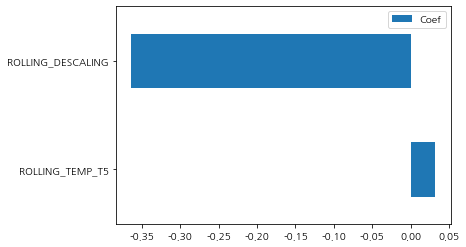

In [46]:
# 설명변수 중요도 
df_logistic_coef = pd.DataFrame({"Coef":log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

## StandardScaler

In [47]:
df_char = df_logi.select_dtypes(include="object")
df_numeric = df_logi.select_dtypes(exclude ="object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

# 범주형데이터는 scaling이 되지 않기 때문에 연속형 변수를 표준화 시킨 후에 컬럼으로 붙인다!
df_scaled = pd.concat([df_numeric_scaled,df_char], axis=1)
df_scaled.head().T

,0,1,2,3,4
SCALE,-0.691564,-0.691564,-0.691564,-0.691564,-0.691564
PT_THK,0.165524,0.165524,0.219261,0.219261,0.485835
PT_WDTH,1.73883,1.73883,1.56826,1.56826,0.558436
PT_LTH,-1.39925,-1.39925,-1.10395,-1.10395,-1.52797
PT_WGT,-1.10266,-1.10266,-0.943272,-0.943272,-1.17328
FUR_NO_ROW,-0.994413,1.00562,-0.994413,1.00562,-0.994413
FUR_HZ_TEMP,-0.55014,-0.55014,-1.27026,-0.166077,-0.742171
FUR_HZ_TIME,0.726729,0.885652,0.726729,0.965114,1.2035
FUR_SZ_TEMP,-0.958762,-0.84445,-1.64463,-1.3017,-1.24454
FUR_SZ_TIME,-0.544799,-0.709067,-0.654311,-0.298397,-0.845957


In [48]:
df_scaled['SCALE']=np.where(df_scaled['SCALE']>0,1,0)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,FUR_NO,WORK_GR
0,0,0.165524,1.738825,-1.399249,-1.102663,-0.994413,-0.550140,0.726729,-0.958762,-0.544799,-0.401705,-0.958762,-0.118132,-0.202656,1호기,2조
1,0,0.165524,1.738825,-1.399249,-1.102663,1.005618,-0.550140,0.885652,-0.844450,-0.709067,-0.379613,-0.844450,-0.072514,-0.202656,1호기,2조
2,0,0.219261,1.568260,-1.103953,-0.943272,-0.994413,-1.270256,0.726729,-1.644633,-0.654311,-0.401705,-1.644633,-0.802387,-0.202656,2호기,3조
3,0,0.219261,1.568260,-1.103953,-0.943272,1.005618,-0.166077,0.965114,-1.301698,-0.298397,0.349415,-1.301698,-0.863210,-0.202656,2호기,3조
4,0,0.485835,0.558436,-1.527970,-1.173279,-0.994413,-0.742171,1.203499,-1.244542,-0.845957,0.305232,-1.244542,-1.045678,-0.202656,3호기,1조


In [49]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled,
                                                  test_size=0.3,
                                                  random_state=1234)

In [50]:
scaled_log_model =Logit.from_formula("SCALE ~ROLLING_TEMP_T5+ROLLING_DESCALING", df_scaled_train)

scaled_log_result = scaled_log_model.fit()

print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.410445
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  499
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                  0.3393
Time:                        20:42:40   Log-Likelihood:                -204.81
converged:                       True   LL-Null:                       -309.97
Covariance Type:            nonrobust   LLR p-value:                 2.138e-46
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2145      0.143     -8.509      0.000      -1.494      -0.935
ROLLING_

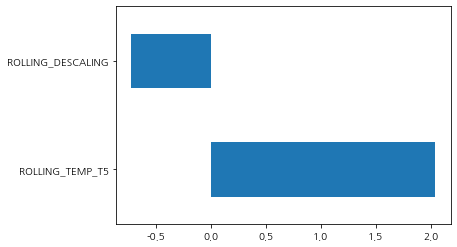

In [51]:
df_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},
                                 index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend=False)

표준화를 시킨후 변수중요도를 살펴본 결과, ROLLING_TEMP_T5가 가장 큰 영향을 주고 있다는 것을 알 수 있었다.

### 2. Decision Tree

In [52]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, df_y, test_size=0.3, random_state=3850)
print("train size is {}".format(df_train_x.shape))
print("test size is {}".format(df_test_x.shape))

print("test size is {}".format(df_test_y.shape))

train size is (499, 54)
test size is (215, 54)
test size is (215,)


In [53]:
tree_uncustomized =  DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print("Accuracy on training set : {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set : 1.000
Accuracy on test set : 0.953


##### Depth 정하기

In [54]:
train_accuracy =[]; test_accuracy=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DecisionTreeClassifier(max_depth=v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth']=para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.892,0.884
1,2,0.934,0.930
2,3,0.964,0.958
3,4,0.970,0.967
4,5,0.972,0.967
5,6,0.976,0.967
6,7,0.976,0.967
7,8,0.978,0.967
8,9,0.980,0.963
9,10,0.982,0.953


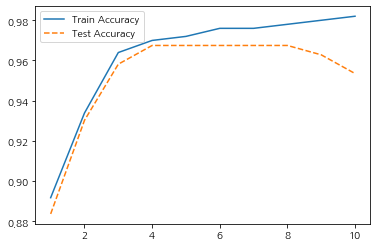

In [55]:
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

최대 깊이를 감소시키면 깊이 제약으로 과대적합을 방지 할 수있기 때문에 4를 선택한다.

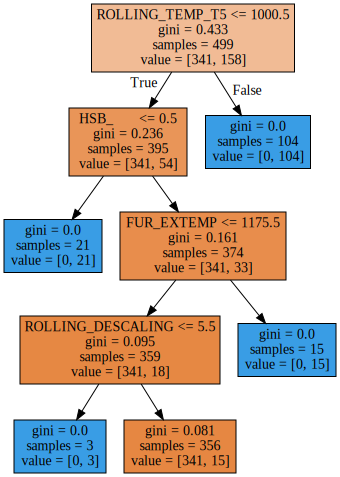

In [56]:
v_feature_name = df_train_x.columns


# 노드의 최소 자료수=8 모델
tree_graph=DecisionTreeClassifier(random_state=1234,max_depth=4)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_depth.dot", feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_depth.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### min_samples_split 정하기

In [57]:
train_accuracy =[]; test_accuracy=[]

para_split = [n_split*10 for n_split in range(1,15)]

for v_min_samples_split in para_split:
    tree=DecisionTreeClassifier(max_depth=4,
                                min_samples_split=v_min_samples_split,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split']=para_split
df_accuracy_split['TrainAccuracy']=train_accuracy
df_accuracy_split['TestAccuracy']=test_accuracy

df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.97,0.967
1,20,0.97,0.967
2,30,0.97,0.967
3,40,0.97,0.967
4,50,0.97,0.967
5,60,0.97,0.967
6,70,0.97,0.967
7,80,0.97,0.967
8,90,0.97,0.967
9,100,0.97,0.967


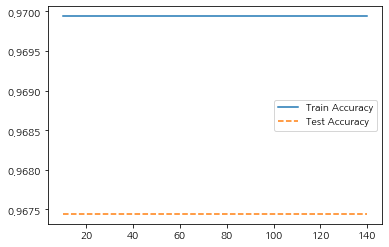

In [58]:
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

분리 노드의 최소자료 수 변경에 따른 모델 성능이 일정하기 때문에 train데이터의 수(499개)를 고려하여 40을 선택한다.

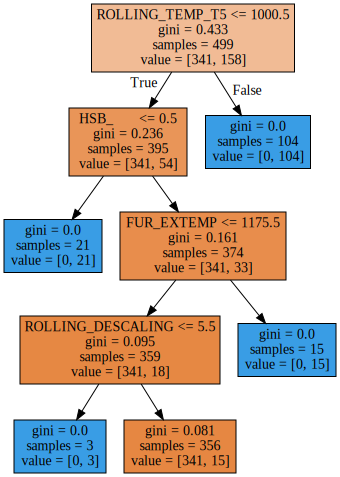

In [59]:
v_feature_name = df_train_x.columns


# 노드의 최소 자료수=8 모델
tree_graph=DecisionTreeClassifier(random_state=1234,max_depth=4,
                                 min_samples_split=40)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_split.dot", feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_split.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### min_samples_leaf정하기

In [60]:
train_accuracy =[]; test_accuracy=[]

para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeClassifier(max_depth=4,
                                min_samples_split=40,
                                min_samples_leaf=v_min_samples_leaf
                                ,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy
0,2,0.970,0.967
1,4,0.964,0.958
2,6,0.964,0.958
3,8,0.964,0.958
4,10,0.964,0.958
5,12,0.964,0.958
6,14,0.964,0.958
7,16,0.960,0.953
8,18,0.954,0.940
9,20,0.954,0.940


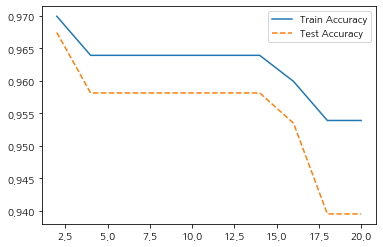

In [61]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능이 점차 감소하는 추세를 보여주므로 train데이터의 수 (499개)와 분리노드의 최소 자료수 40을 고려하여 10을 선택한다.

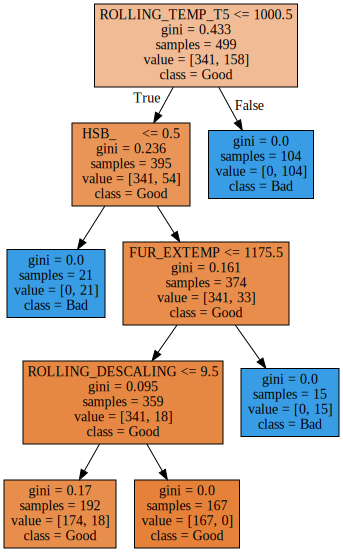

In [62]:
v_feature_name = df_train_x.columns

tree_graph=DecisionTreeClassifier(random_state=1234,max_depth=4,
                                 min_samples_split=40,
                                 min_samples_leaf=10)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_low.dot", feature_names=v_feature_name, impurity=True, filled=True,
               class_names=['Good','Bad'])

with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### 최종 모델 선정

In [63]:
tree_final = DecisionTreeClassifier(max_depth=4, min_samples_split=40,
                                   min_samples_leaf=4, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

**최종 모델 시각화**

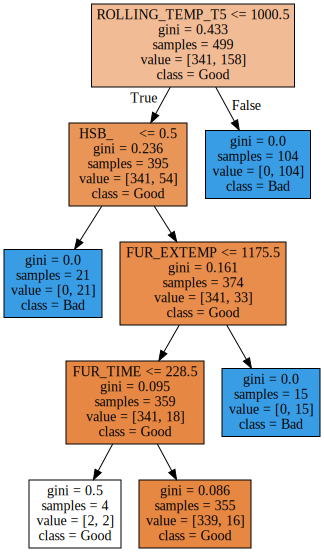

In [105]:

export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity=True, filled=True,
               class_names=['Good','Bad'])

with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### 최종 모델 평가

In [65]:
y_pred = tree_final.predict(df_test_x)

train.append(tree_final.score(df_train_x, df_train_y))
test.append(tree_final.score(df_test_x, df_test_y))

fpr, tpr, thresholds =roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

model_auc_score.append(roc_auc)
print("Accuracy:{0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix :\n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy:0.958

Confusion matrix :
[[142   0]
 [  9  64]]


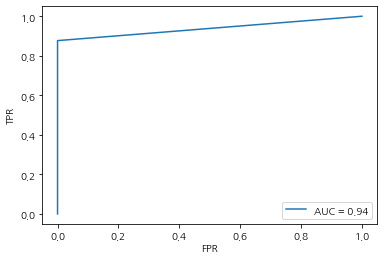

In [66]:
plt.plot(fpr,tpr,label="AUC = %0.2f"%roc_auc)
plt.legend(loc='lower right')
plt.ylabel("TPR"); plt.xlabel("FPR")
plt.show()

In [67]:
#f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))
model_precision_score.append(precision_score(df_test_y, y_pred))
model_recall_score.append(recall_score(df_test_y, y_pred))

설명변수의 중요도 확인하기


Text(0, 0.5, '설명변수')

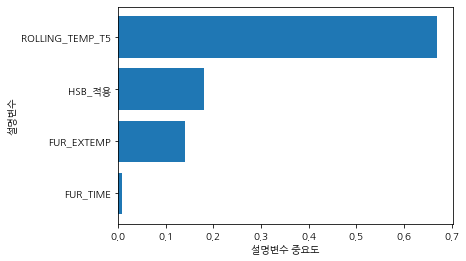

In [68]:
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.feature_importances_

df_importance=df_importance[df_importance['Importance']>0]
df_importance.sort_values("Importance", ascending=True, inplace=True)
corrdinates =range(len(df_importance))
plt.barh(y=corrdinates, width = df_importance['Importance'])
plt.yticks (corrdinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

ROLLING_TEMP_T5 > HSB  > FUR_EXTEMP > FUR_TIME 순으로 설명변수 중요도가 높다고 나왔다.  

1위로 나온 ROLLING_TEMP_T5는 로지스틱 회귀분석에서도 중요하다고 판단한 설명변수이므로 다른 모델에서도 집중할 필요가 있다

### 3. Random Forest

In [69]:
tree_uncustomized =  RandomForestClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print("Accuracy on training set : {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set : 0.998
Accuracy on test set : 0.940


##### n_estimator 정하기

In [70]:
train_accuracy =[]; test_accuracy=[]

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    tree=RandomForestClassifier(n_estimators=v_n_estimators, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators']=para_n_tree
df_accuracy_n['TrainAccuracy']=train_accuracy
df_accuracy_n['TestAccuracy']=test_accuracy

df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.998,0.940
1,20,0.998,0.953
2,30,1.000,0.953
3,40,1.000,0.953
4,50,1.000,0.958
5,60,1.000,0.958
6,70,1.000,0.958
7,80,1.000,0.958
8,90,1.000,0.958
9,100,1.000,0.958


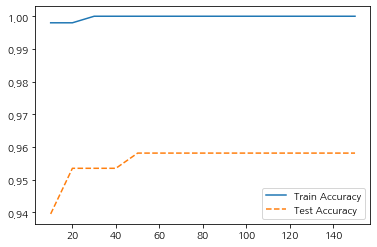

In [71]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

n_estimators : 트리 수 변경에 따른 모델 oob error 변화

In [72]:
oob_error=[]

for v_n_estimator in range(1,151):
    rf = RandomForestClassifier(n_estimators=v_n_estimator, oob_score=True, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1-rf.oob_score_)

Text(0.5, 0, 'n_estimators')

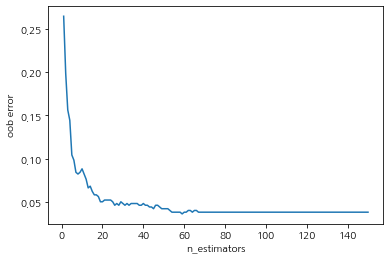

In [73]:
plt.plot(range(1,151), oob_error)
plt.ylabel("oob error")
plt.xlabel('n_estimators')


    생성하는 결정 트리 수 증가에 따라 모델의 정확도는 증가하며 OOB Error는 감소,
    모델의 특성을 고려하여 60 선택

##### Depth 정하기

In [74]:
train_accuracy =[]; test_accuracy=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=RandomForestClassifier(n_estimators=60,max_depth=v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth']=para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.685,0.660
1,2,0.892,0.879
2,3,0.950,0.930
3,4,0.962,0.958
4,5,0.964,0.958
5,6,0.966,0.958
6,7,0.968,0.958
7,8,0.978,0.958
8,9,0.994,0.958
9,10,0.998,0.958


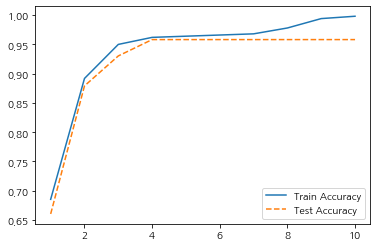

In [75]:
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

    최대 깊이 증가에 따라 모델의 정확도는 증가하며 4를 기점으로 Test데이터의 score가 일정하므로 Train/Test 데이터의 성능 변화를 고려하여 4 선택

##### min_samples_split 정하기

In [76]:
train_accuracy =[]; test_accuracy=[]

para_split = [n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree=RandomForestClassifier(n_estimators=60,max_depth=4,
                                min_samples_split=v_min_samples_split,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split']=para_split
df_accuracy_split['TrainAccuracy']=train_accuracy
df_accuracy_split['TestAccuracy']=test_accuracy

df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.960,0.958
1,20,0.960,0.958
2,30,0.962,0.953
3,40,0.962,0.949
4,50,0.958,0.949
5,60,0.960,0.949
6,70,0.954,0.949
7,80,0.960,0.953
8,90,0.948,0.935
9,100,0.948,0.940


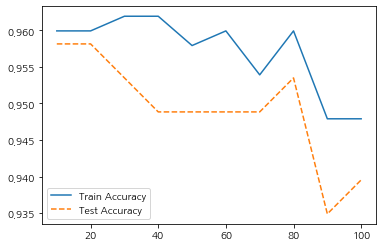

In [77]:
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

    분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소하나 특히 20을 기점으로 test 데이터의 성능이 현저하게 떨어지게 되므로 20을 선택한다.

##### min_samples_leaf정하기

In [78]:
train_accuracy =[]; test_accuracy=[]

para_leaf = [n_leaf*10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree=RandomForestClassifier(n_estimators=60,max_depth=4,
                                min_samples_split=20,
                                min_samples_leaf=v_min_samples_leaf
                                ,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy
0,10,0.932,0.907
1,20,0.876,0.856
2,30,0.880,0.874
3,40,0.870,0.865
4,50,0.874,0.865
5,60,0.862,0.865
6,70,0.856,0.847
7,80,0.818,0.814
8,90,0.790,0.767
9,100,0.683,0.660


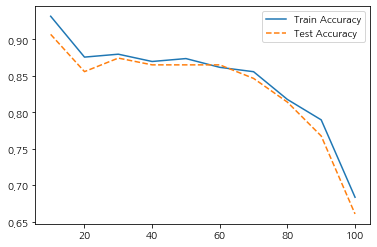

In [79]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

    잎사귀 노드 최소 자료 수 증가에 따라 모델의 정확도는 감소하며
    Train/Test 데이터의 성능 변화를 고려하여 10 선택

##### 최종 모델 선정

In [80]:
rf_final = RandomForestClassifier(n_estimators=60,max_depth=4, min_samples_split=20,
                                   min_samples_leaf=10, random_state=1234)
rf_final.fit(df_train_x, df_train_y)

y_pred = rf_final.predict(df_test_x)


train.append(rf_final.score(df_train_x, df_train_y))
test.append(rf_final.score(df_test_x, df_test_y))

fpr, tpr, thresholds =roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

model_auc_score.append(roc_auc)

print("Accuracy on training set : {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

print("Confusion matrix : \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set : 0.932
Accuracy on test set : 0.907
Confusion matrix : 
[[142   0]
 [ 20  53]]


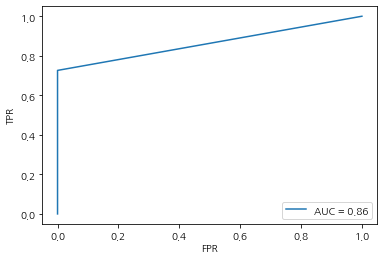

In [81]:
plt.plot(fpr,tpr,label="AUC = %0.2f"%roc_auc)
plt.legend(loc='lower right')
plt.ylabel("TPR"); plt.xlabel("FPR")
plt.show()

In [82]:
#f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))
model_precision_score.append(precision_score(df_test_y, y_pred))
model_recall_score.append(recall_score(df_test_y, y_pred))

train/test 데이터의 정분류율이 비슷한 수준(**90.7%**)으로 안정적인 모델임을 확인할 수 있음

In [83]:
v_feature_name = df_train_x.columns

df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
11,ROLLING_TEMP_T5,0.272
1,PT_WDTH,0.123
7,FUR_SZ_TEMP,0.089
10,FUR_EXTEMP,0.087
0,PT_THK,0.058
12,ROLLING_DESCALING,0.052
8,FUR_SZ_TIME,0.045
13,STEEL_KIND_C0,0.044
5,FUR_HZ_TEMP,0.040
25,HSB_미적용,0.035


Text(0, 0.5, '설명변수')

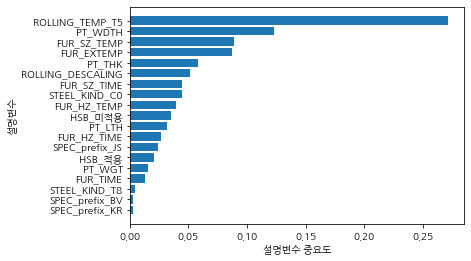

In [84]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance=df_importance[df_importance['Importance']>0.002]
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("설명변수 중요도")
plt.ylabel('설명변수')

ROLLING_TEMP_T5 > PT_WDTH  > FUR_SZ_TEMP > FUR_EXTEP 순으로 설명변수 중요도가 높다고 나왔다.  

1위로 나온 ROLLING_TEMP_T5는 로지스틱 회귀분석과 의사결정 나무에서도 중요하다고 판단한 설명변수로 계속해서 설명변수 중요도의 상위권에 머무르며 SCALE에 영향을 많이 주고 있는 변수임을 말해주고 있다.

### 4. Gradient Boosting

In [85]:
tree_uncustomized =  GradientBoostingClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print("Accuracy on training set : {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set : 1.000
Accuracy on test set : 0.972


learning rate : 학습률 변경에 따른 모델 성능

In [86]:
train_accuracy = []; test_accuracy=[]

para_lr = [lr*0.01 for lr in range(1,20)]

for v_learning_rate in para_lr:
    gb=GradientBoostingClassifier(learning_rate=v_learning_rate, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate']=para_lr
df_accuracy_lr['TrainAccuracy']=train_accuracy
df_accuracy_lr['TestAccuracy']=test_accuracy

df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.01,0.964,0.958
1,0.02,0.970,0.967
2,0.03,0.980,0.967
3,0.04,0.988,0.977
4,0.05,0.994,0.977
5,0.06,0.998,0.972
6,0.07,0.998,0.981
7,0.08,0.998,0.972
8,0.09,1.000,0.972
9,0.10,1.000,0.972


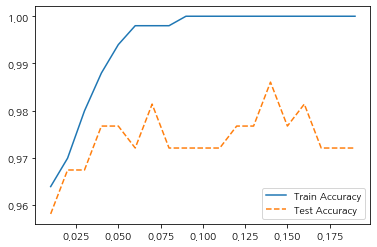

In [87]:
plt.plot(para_lr, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

learning rate가 0.05이상일 때 train score가 0.97~0.98 정도로 안정되기 때문에 0.05 이후 중 가장 높은 값을 갖는 0.14 선택

##### n_estimator 정하기

In [88]:
train_accuracy =[]; test_accuracy=[]

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    tree=GradientBoostingClassifier(learning_rate=0.14,n_estimators=v_n_estimators, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators']=para_n_tree
df_accuracy_n['TrainAccuracy']=train_accuracy
df_accuracy_n['TestAccuracy']=test_accuracy

df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.964,0.958
1,20,0.978,0.967
2,30,0.992,0.981
3,40,0.998,0.981
4,50,0.998,0.981
5,60,1.000,0.986
6,70,1.000,0.986
7,80,1.000,0.986
8,90,1.000,0.986
9,100,1.000,0.986


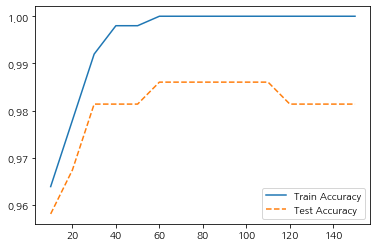

In [89]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

score가 안정적으로 높게 나오고 있고, 전체 데이터의 수가 499개이므로 모델의 특성을 고려하여 70 선택

##### Depth 정하기

In [90]:
train_accuracy =[]; test_accuracy=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=GradientBoostingClassifier(learning_rate=0.14,n_estimators=70,max_depth=v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth']=para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.970,0.967
1,2,0.996,0.986
2,3,1.000,0.986
3,4,1.000,0.972
4,5,1.000,0.967
5,6,1.000,0.967
6,7,1.000,0.986
7,8,1.000,0.958
8,9,1.000,0.972
9,10,1.000,0.967


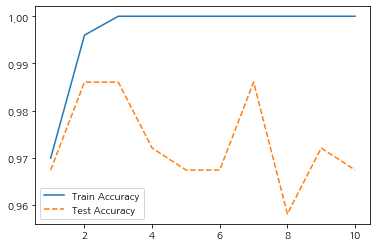

In [91]:
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

최대 깊이는 클 수록 과대적합의 여지가 생기기 때문에 3과 7중 더 작은 3을 선택하겠다.

##### min_samples_split 정하기

In [92]:
train_accuracy =[]; test_accuracy=[]

para_split = [n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree=GradientBoostingClassifier(learning_rate=0.14,n_estimators=60,max_depth=3,
                                min_samples_split=v_min_samples_split,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split']=para_split
df_accuracy_split['TrainAccuracy']=train_accuracy
df_accuracy_split['TestAccuracy']=test_accuracy

df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.998,0.972
1,20,1.000,0.981
2,30,0.998,0.981
3,40,0.998,0.981
4,50,0.998,0.981
5,60,0.998,0.981
6,70,0.998,0.981
7,80,0.998,0.981
8,90,0.998,0.981
9,100,0.998,0.981


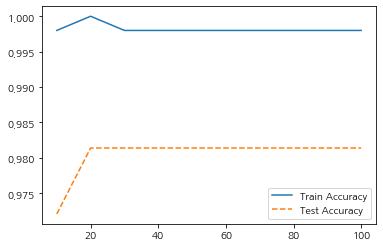

In [93]:
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

    분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 차이가 존재하나 test 데이터의 성능 변화를 고려하면 30정도에서 안정성을 보여준다고 판단하여 30으로 결정함

##### min_samples_leaf정하기

In [94]:
train_accuracy =[]; test_accuracy=[]

para_leaf = [n_leaf*5 for n_leaf in range(1,7)]

for v_min_samples_leaf in para_leaf:
    tree=GradientBoostingClassifier(learning_rate=0.14,n_estimators=60,max_depth=3,
                                min_samples_split=30,
                                min_samples_leaf=v_min_samples_leaf
                                ,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy
0,5,0.992,0.972
1,10,0.996,0.981
2,15,0.996,0.991
3,20,0.992,0.967
4,25,0.954,0.912
5,30,0.958,0.912


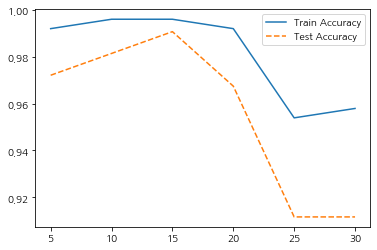

In [95]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

    과적합 요소를 배제하고 전체데이터 개수(499개)와 Train/Test 데이터의 성능 변화를 고려하여 15 선택

##### 최종 모델 선정

In [96]:
gb_final = GradientBoostingClassifier(learning_rate=0.14, n_estimators=60,max_depth=3, min_samples_split=60,
                                   min_samples_leaf=25, random_state=1234)
gb_final.fit(df_train_x, df_train_y)

y_pred = rf_final.predict(df_test_x)

print("Accuracy on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))
print("Confusion matrix : \n{}".format(confusion_matrix(df_test_y, y_pred)))

train.append(gb_final.score(df_train_x, df_train_y))
test.append(gb_final.score(df_test_x, df_test_y))

fpr, tpr, thresholds =roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

model_auc_score.append(roc_auc)

Accuracy on training set : 0.956
Accuracy on test set : 0.912
Confusion matrix : 
[[142   0]
 [ 20  53]]


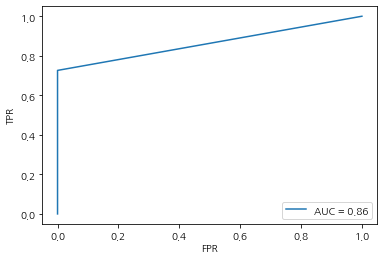

In [97]:
plt.plot(fpr,tpr,label="AUC = %0.2f"%roc_auc)
plt.legend(loc='lower right')
plt.ylabel("TPR"); plt.xlabel("FPR")
plt.show()

In [98]:
#f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))
model_precision_score.append(precision_score(df_test_y, y_pred))
model_recall_score.append(recall_score(df_test_y, y_pred))

train/test 데이터의 정분류율이 비슷한 수준(**91.2%**)으로 안정적인 모델임을 확인할 수 있음

In [99]:
v_feature_name = df_train_x.columns

df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
11,ROLLING_TEMP_T5,0.743
5,FUR_HZ_TEMP,0.063
7,FUR_SZ_TEMP,0.044
0,PT_THK,0.035
12,ROLLING_DESCALING,0.026
3,PT_WGT,0.024
8,FUR_SZ_TIME,0.016
10,FUR_EXTEMP,0.012
2,PT_LTH,0.011
9,FUR_TIME,0.008


Text(0, 0.5, '설명변수')

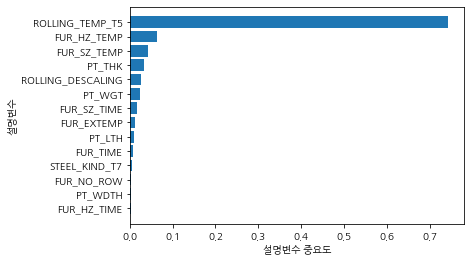

In [100]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance=df_importance[df_importance['Importance']>0.002]
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("설명변수 중요도")
plt.ylabel('설명변수')

ROLLING_TEMP_T5 > FUR_HZ_TEMP  > FUR_SZ_TEMP > PT_THK 순으로 설명변수 중요도가 높다고 나왔다.  

1위로 나온 ROLLING_TEMP_T5는 로지스틱 회귀분석과 의사결정 나무에서도 중요하다고 판단한 설명변수로 계속해서 설명변수 중요도의 상위권에 머무르며 SCALE에 영향을 많이 주고 있는 변수임을 말해주고 있다.

## 모델 평가

In [101]:
df_eval = pd.DataFrame(index=model)
df_eval['Train Accuracy']=train
df_eval['Test Accuracy']=test
df_eval['F1 Score']=model_f1_score
df_eval['AUC']=model_auc_score
df_eval['Precision Score']=model_precision_score
df_eval['Recall Score']=model_recall_score
df_eval.round(3)

,Train Accuracy,Test Accuracy,F1 Score,AUC,Precision Score,Recall Score
DecisionTree,0.964,0.958,0.934,0.938,1.0,0.877
RandomForest,0.932,0.907,0.841,0.863,1.0,0.726
GradientBoosing,0.956,0.912,0.841,0.863,1.0,0.726


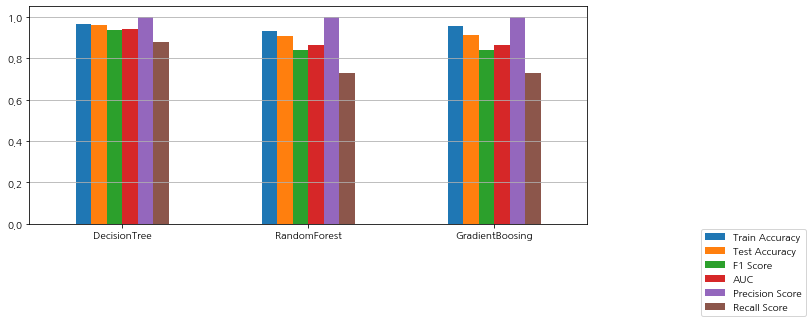

In [102]:
df_eval.plot.bar(rot=0,figsize=(10,4))
plt.legend(loc='best', bbox_to_anchor=(1.4,0))
plt.grid(axis='y')

F1점수는 정밀도(Precision)와 재현율(Recall) 지수를 활용한 분류의 정확도 지수로 목표변수가 편향된 경우 사용되며 특정 분류값에 의존하지 않고 모델의 우수성을 비교 할 수 있다.  

위 3가지 모델에서 F1점수가 높았던 모델은 **Decision Tree**로 특정 분류 기준값에 의존하지 않고 모델의 우수성을 비교할 수 있는 AUC 역시 가장 높았다.

# 결론

Scale 불량을 줄이기 위하여 엔지니어들과의 협의한 잠재 원인
    
    
|SCALE발생|가열로 가열대온도|가열로 균열대온도|가열로 추출온도|Hot Scale Breaker|사상 압연 온도|압연간 Descaling 횟수|판두께|
|-----|---|-------|----|-----|---|---|---|
|없음|저|저|저|적용|저|증가|후|
|발생|고|고|고|미적용|고|감소|박|

엔지니어들이 도출한 잠재적 원인에 대해 EDA를 진행한 결과 
* 가열로 가열대온도 : 가열대 온도가 1152도 이상 1184도 이하 일때 양품 대비 불량률이 높았다.
* 가열로 균열대온도 : 균열대 온도가 1146도 이상 1166 이하 일때 양품 대비 불량률이 높았다.
* 가열로 추출온도 : 추출 온도가 1152도이상 1154도 이하일 때와 1164도 일때 양품 대비 불량률이 높았다. 
* Hot Scale Breaker : HSB를 적용하지 않은 경우에는 모든 생산 제품에서 SCALE이 발생하였다.
* 사상 압연온도 : 압연온도가 1000도 이상일때 생산되는 모든 제품에서 SCALE이 발생하였다.
* 압연간 Descaling 횟수 : Descaling을 7회 이상 시행한 경우 불량률이 급격히 증가하다 10회 이후부터는 감소하였다.
* 판두께 : 판두께가 50이하일때 불량률이 높았다.